In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import math
import numpy as np

In [4]:
# Reads results csv files into df
def read_csv(path):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (pd.read_csv(file) for file in csv_files)
    full_df = pd.concat(df_list, ignore_index=True)
    full_df.columns = [c.replace(' ', '_') for c in full_df.columns]
    return full_df

In [5]:
# Separates and plots rewards
r_disc = -11  # reward for discarded product
r_nex = -50  # reward nonexistent


def plot_reward(df, title):
    # Multiple number of nonexistent issues by r_nex
    reward_nex = r_nex * df['issued_but_nonexistent']
    # Reward for issued but discarded
    reward_disc = r_disc * df['issued_but_discarded']
    # Reward for outdated products
    reward_out = -1 * df['num_outdates']

    # Remaining reward
    reward_rem = df['reward'] - reward_disc - reward_nex - reward_out

    plt.plot(mov_avg(reward_disc), label='discarded')
    plt.plot(mov_avg(reward_nex), label='non existing')
    plt.plot(mov_avg(reward_out), label='outdates')

    # Plot episode lines
    x = [*range(0, len(df), 982)]
    [plt.axvline(_x, linewidth=0.40, color='b') for _x in x]

    plt.legend(loc="lower right")

    plt.xlabel('Days')
    plt.ylabel('Reward')
    plt.title(title)

    plt.show()

In [7]:
def mov_avg(data):
    data = np.array(data)
    window_width = 500
    cumsum_vec = np.cumsum(np.insert((data), 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

In [8]:
def plot_multi(dfs):
    r_nex = -50
    r_disc = -11

    cols = 2
    rows = math.ceil(len(dfs) / cols)
    width = 12
    if rows == 1:
        width = 6

    fig, axes = plt.subplots(rows, cols, figsize=(16, width), squeeze=False)
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Reward non-existing
                reward_nex = r_nex * dfs[key]['issued_but_nonexistent']
                # Reward for issued but discarded
                reward_disc = r_disc * dfs[key]['issued_but_discarded']
                # Outdated product reward  = -1
                reward_out = -1 * dfs[key]['num_outdates']

                # Remaining reward
                # reward_rem = dfs[key]['reward'] - reward_disc - reward_nex - reward_out
                axes[i][j].plot(mov_avg(reward_disc), label='discarded')
                axes[i][j].plot(mov_avg(reward_nex), label='non-existing')
                axes[i][j].plot(mov_avg(reward_out), label='outdated')
                # axes[i][j].plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='compatible')
                axes[i][j].set(xlabel="Days", ylabel="Reward")
                axes[i][j].legend(loc='lower right')
                axes[i][j].set_title(dict_keys[l])

                # Plot episode lines
                x = [*range(0, len(dfs[key]), 982)]
                [axes[i][j].axvline(_x, linewidth=0.40, color='b') for _x in x]

            l += 1
    plt.tight_layout()
    plt.show()

In [9]:
def plot_multi_satisfied(dfs):
    cols = 2
    rows = math.ceil(len(dfs) / cols)
    width = 12
    if rows == 1:
        width = 6
    fig, axes = plt.subplots(rows, cols, figsize=(16, width), squeeze=False)
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Number satisfied requests
                s = dfs[key]['num_units_requested'] - dfs[key]['issued_but_nonexistent'] - dfs[key][
                    'issued_but_discarded']
                r = dfs[key]['num_units_requested']
                perc = np.array(s / r)

                # Plot episode lines
                x = [*range(0, len(dfs[key]), 982)]
                [axes[i][j].axvline(_x, linewidth=0.40, color='b') for _x in x]

                axes[i][j].plot(mov_avg(perc), label='percentage satisifed')

                axes[i][j].set(xlabel="Days", ylabel="Percentage")
                axes[i][j].legend(loc='lower right')
                axes[i][j].set_title(dict_keys[l])
            l += 1
    plt.tight_layout()
    plt.show()

In [10]:
def plot_satisfied(df, title):
    s = df['num_units_requested'] - df['issued_but_nonexistent'] - df['issued_but_discarded']
    r = df['num_units_requested']
    perc = np.array(s / r)

    plt.plot(mov_avg(perc), label='satisfied')

    # Plot episode lines
    x = [*range(0, len(df), 982)]
    [plt.axvline(_x, linewidth=0.40, color='b') for _x in x]

    plt.legend(loc="lower right")

    plt.ylabel('Number units')
    plt.xlabel('Days')

    plt.title(title)

    plt.show()
    return

In [11]:
def plot_loss_multi(dfs, title):
    dict_keys = [k for k in dfs.keys()]

    for k in dict_keys:
        # Exclude first 70 days: these are for initialization. No updates are performed.
        df_loss = dfs[k].loc[dfs[k]['day_loss'] > 70]
        plt.plot(mov_avg(df_loss['day_loss']), label=k)

    # Plot episode lines
    x = [*range(0, len(dfs[dict_keys[0]]), 982)]
    [plt.axvline(_x, linewidth=0.40, color='b') for _x in x]

    plt.legend(loc='lower right')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Days')

    plt.tight_layout()
    plt.show()

### Intro

We continue with a reduced problem space.
Also recreated the implementation in PyTorch which allows use of GPU.
Fixed the *next_state* bug. In the *next_request* function, *self.state* is changed to the next state. This caused the *current_state* and the *next_state* to be the same in the memories appended to the experience replay buffer.

Now, before calling *next_request*, we save a deep_copy of the current_state.

### Network architecture
#### Input size

```
input_size = len(np.ravel(self.env.state))
```

We reduced the state space to an 8 x 9 matrix.
Only 3 major antigens.

Max age of a unit = 5 (0-4)
Max lead time = 3 (0-2)


output = number of actions (8)
state dimension = 8 x 8
8:   number of blood groups
9:   max age (5) + max lead time (3) + current request (1)

input
size = 8 * 9 = 72

#### Model
```
input -> [64, relu] -> [64, relu] -> [output, linear]
```

Random seed = 0

### 1 Epsilon tests

Alpha = 0.001
Gamma = 0.99
Episode = 2.5 years
25 episodes

In [9]:
e02 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.2/target_False/target_250')
e04 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_False/target_250')
e06 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.6/target_False/target_250')
e08 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.8/target_False/target_250')

epsilons = {'ε = 0.2': e02, 'ε = 0.4': e04, 'ε = 0.6': e06, 'ε = 0.8': e08}

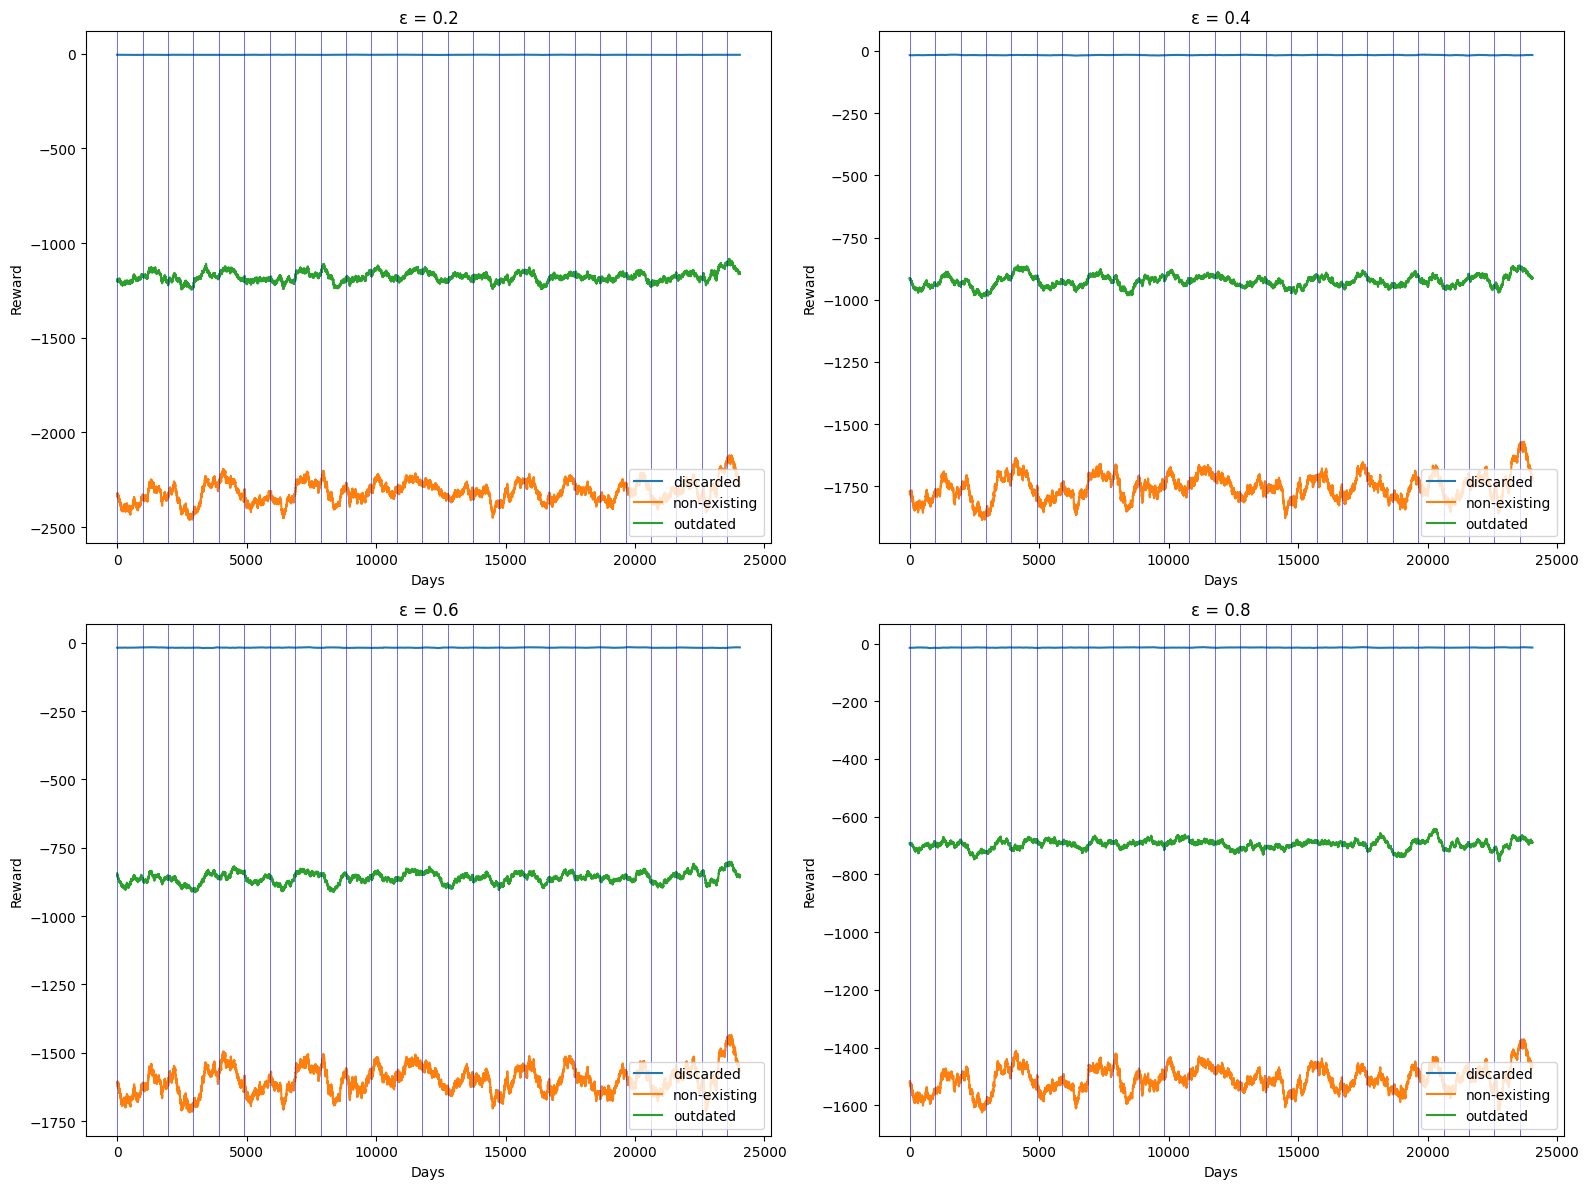

In [10]:
plot_multi(epsilons)

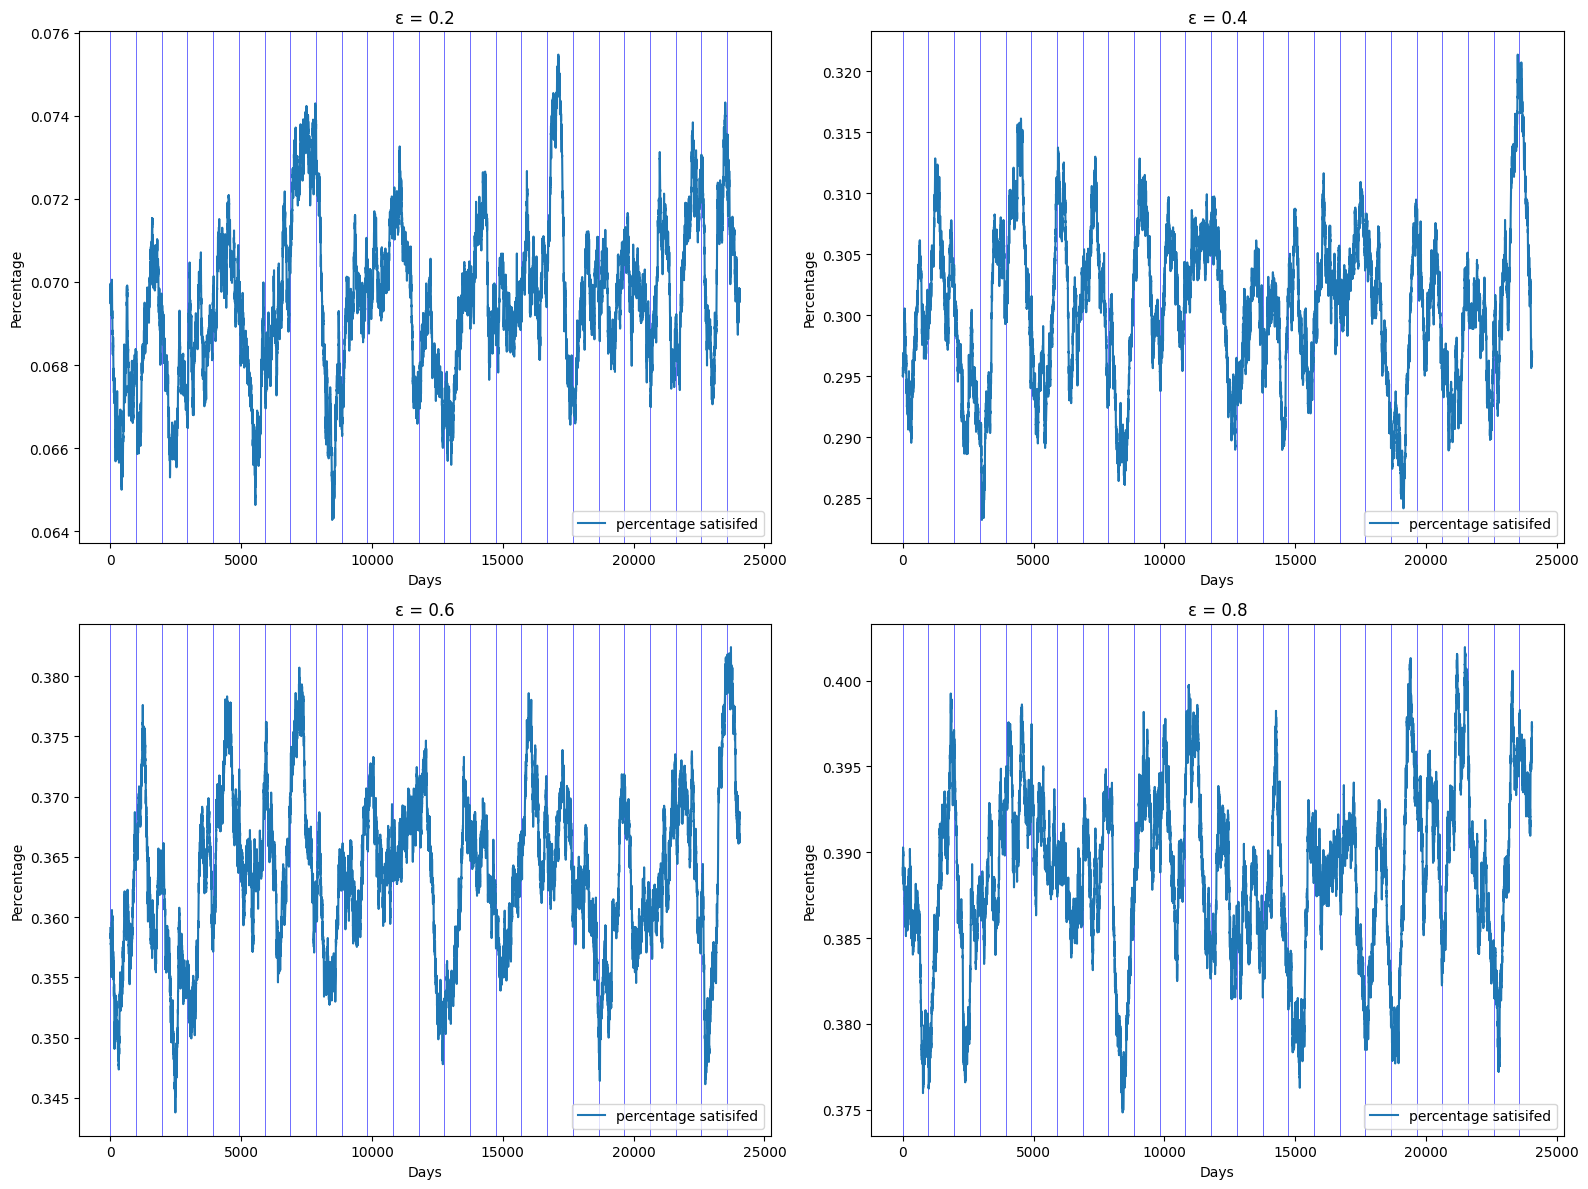

In [11]:
plot_multi_satisfied(epsilons)

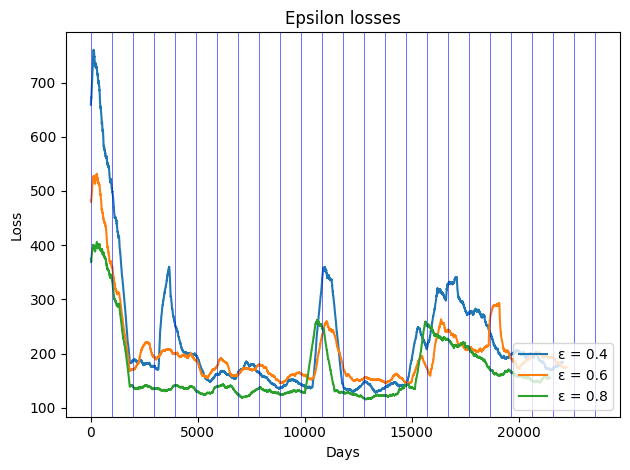

In [12]:
epsilons_468 = {'ε = 0.4': e04, 'ε = 0.6': e06, 'ε = 0.8': e08}
plot_loss_multi(epsilons_468, 'Epsilon losses')

### 2 Target network frequency tests

Epsilon = 0.4
Alpha = 0.001
Episode = 2.5 years
25 episodes

In [13]:
t100 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_100')
t250 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_250')
t500 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_500')
t750 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_750')

targets = {'N = 100': t100, 'N = 250': t250, 'N = 500': t500, 'N = 750': t750}

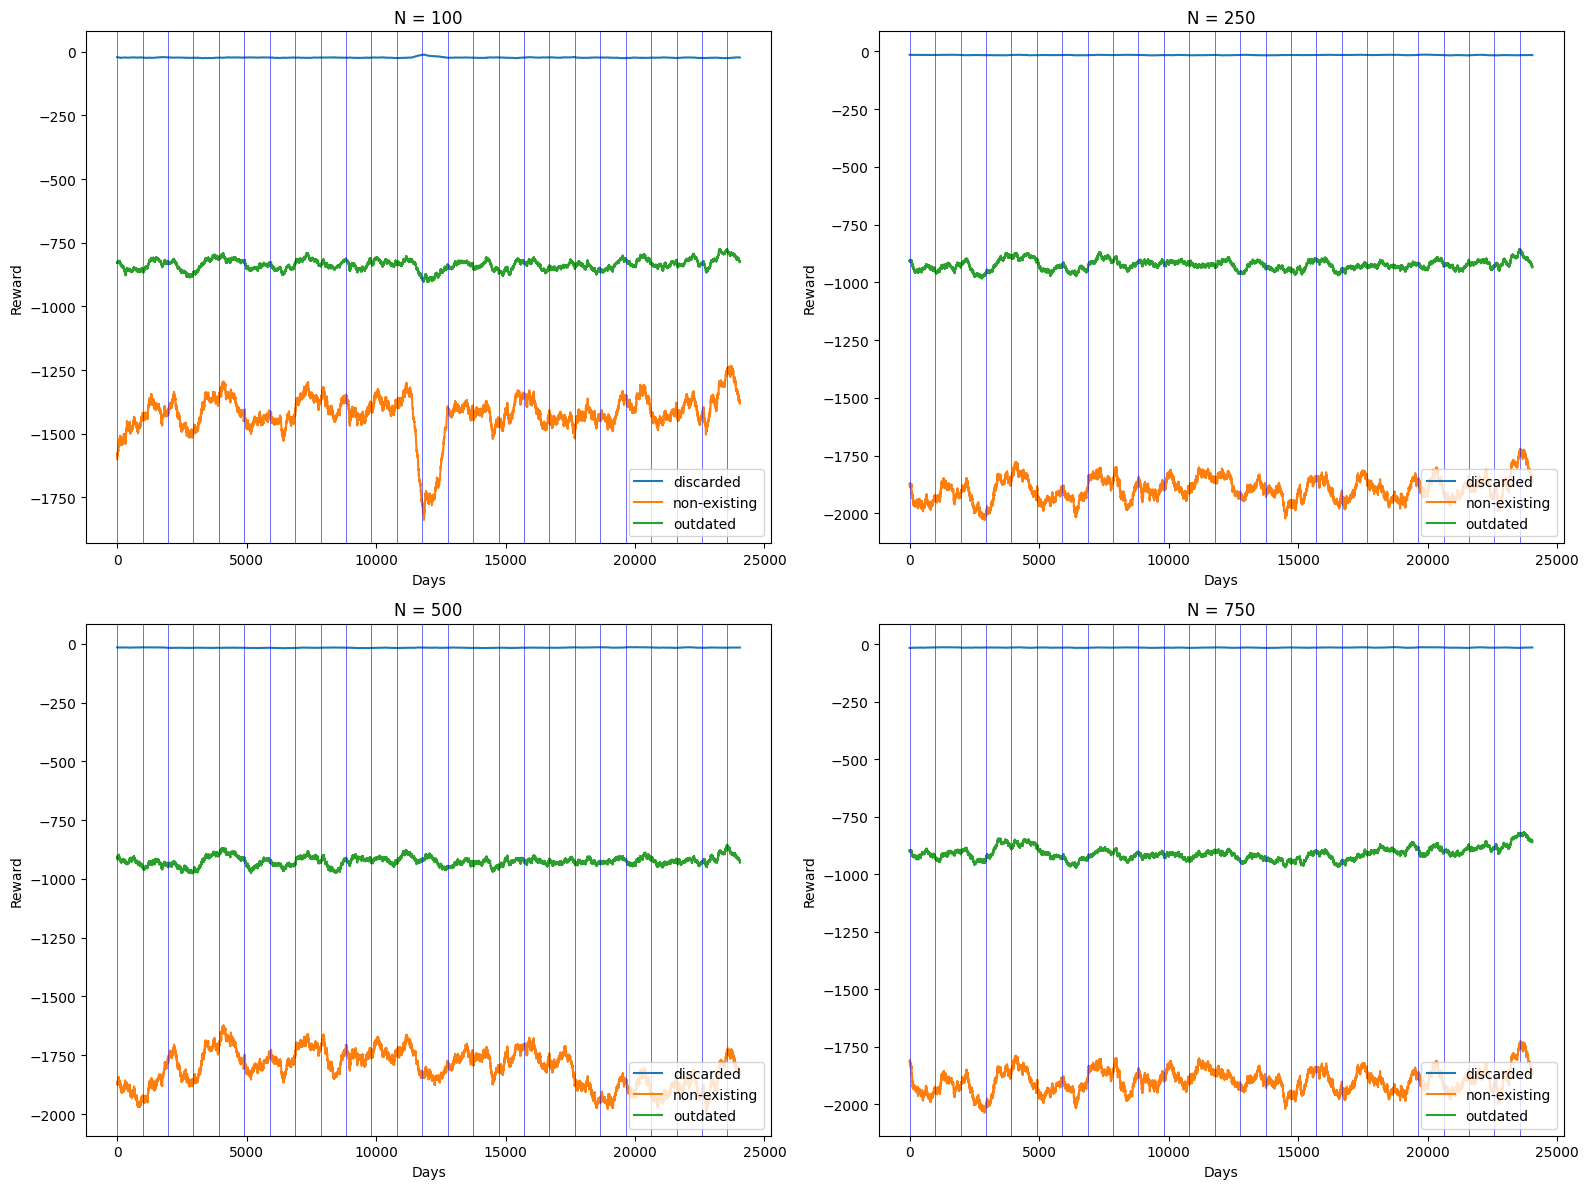

In [14]:
plot_multi(targets)

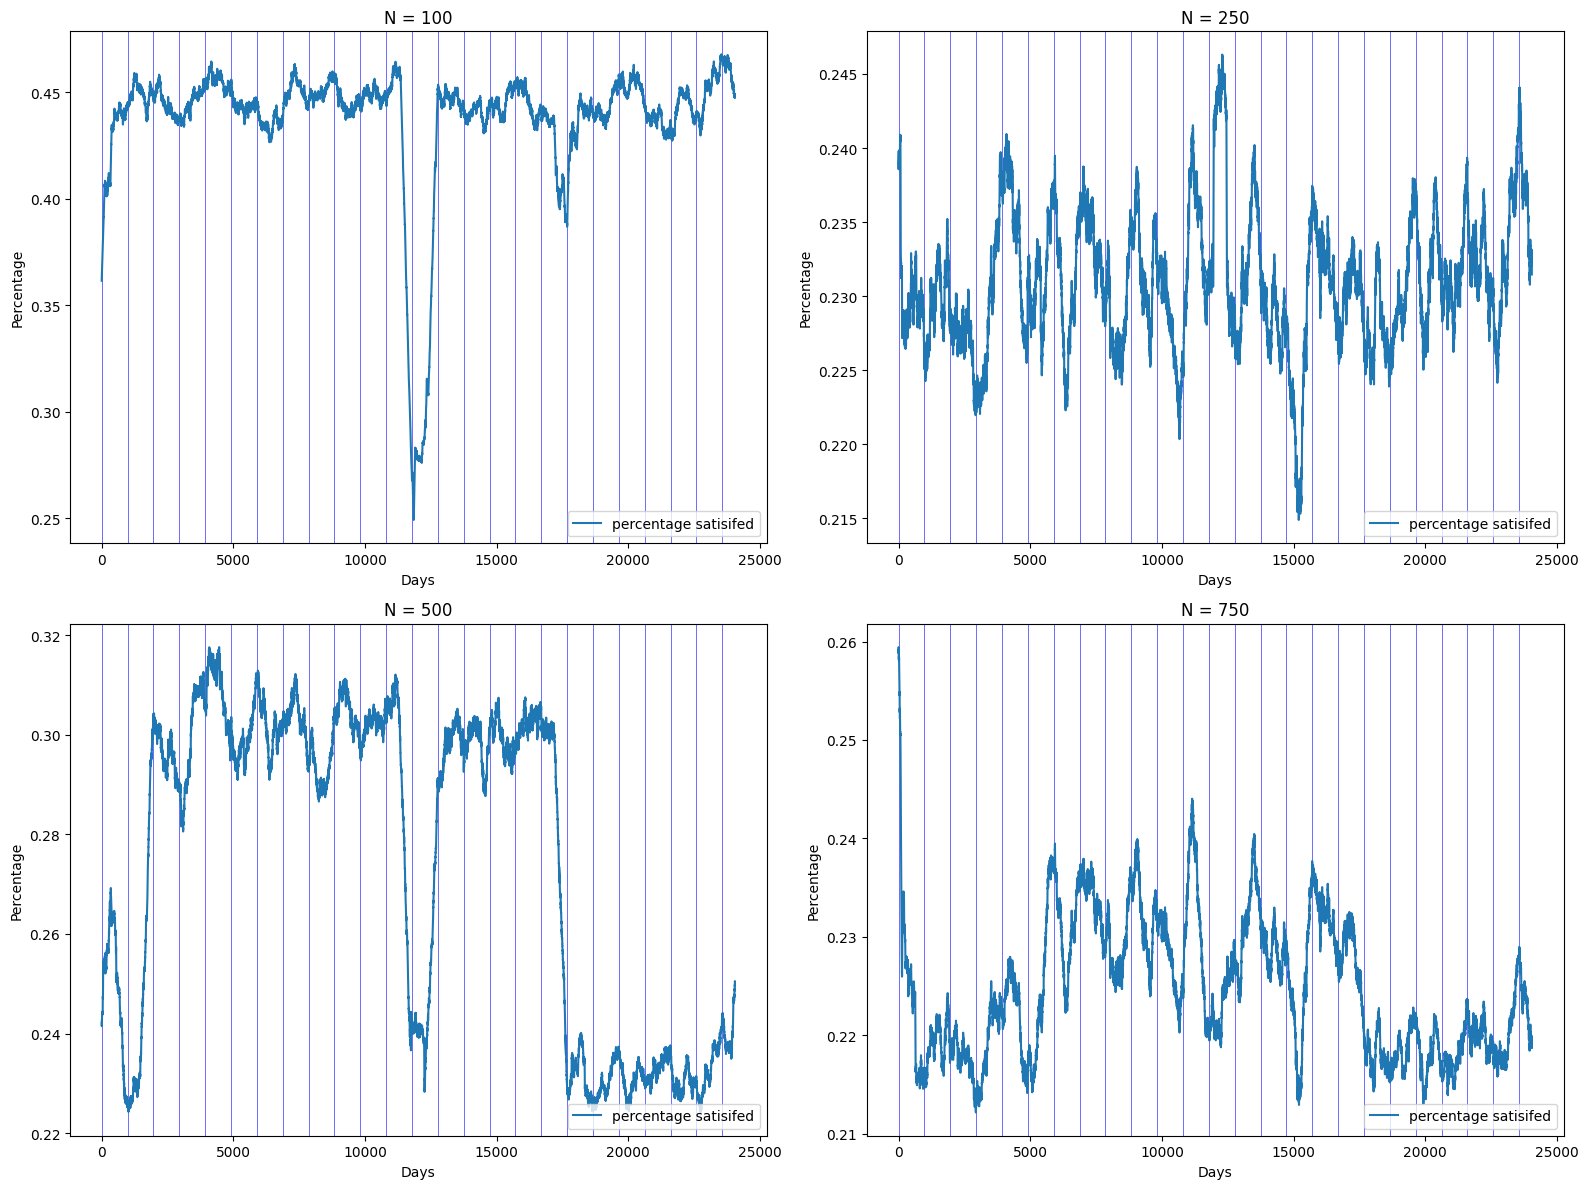

In [15]:
plot_multi_satisfied(targets)

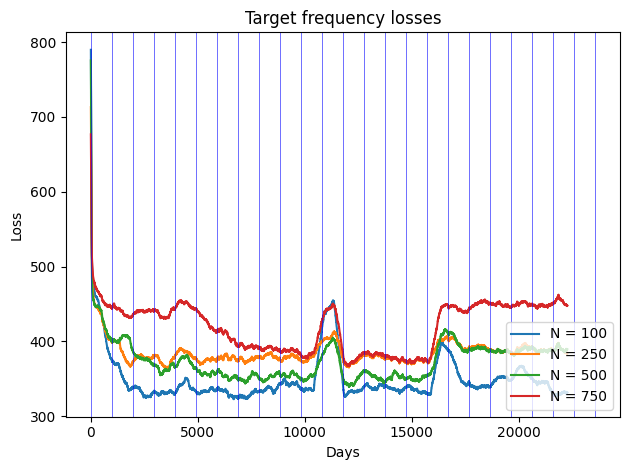

In [16]:
plot_loss_multi(targets, 'Target frequency losses')

### Notes

In the above plots, slight learning is observed. Loss goes down for the most.
We used a fixed random seed (0) for all experiments. More experimenting is required to see if the artifact in episode 13 (and others) mean something.


### 3 Larger network

Network = [128, 128, 128]
Annealing epsilon: 1.0 - 0.1, ends at 80% of episodes (20)

Target update frequency = 100
Episode = 2.5 years
Episodes = 25

alpha = 0.001
Experimented with exp buffer size: 500 or unlimited

In [17]:
df128_exp500 = read_csv('results/request_scratch/a0.001_g0.99_b50/128_128_128/e1.0/target_True/target_100')
df128_expunl = read_csv('results/request_scratch/a0.001_g0.98_b50/128_128_128/e1.0/target_True/target_100')
exps = {'Experience buffer = 500': df128_exp500, 'Experience buffer = ∞': df128_expunl}

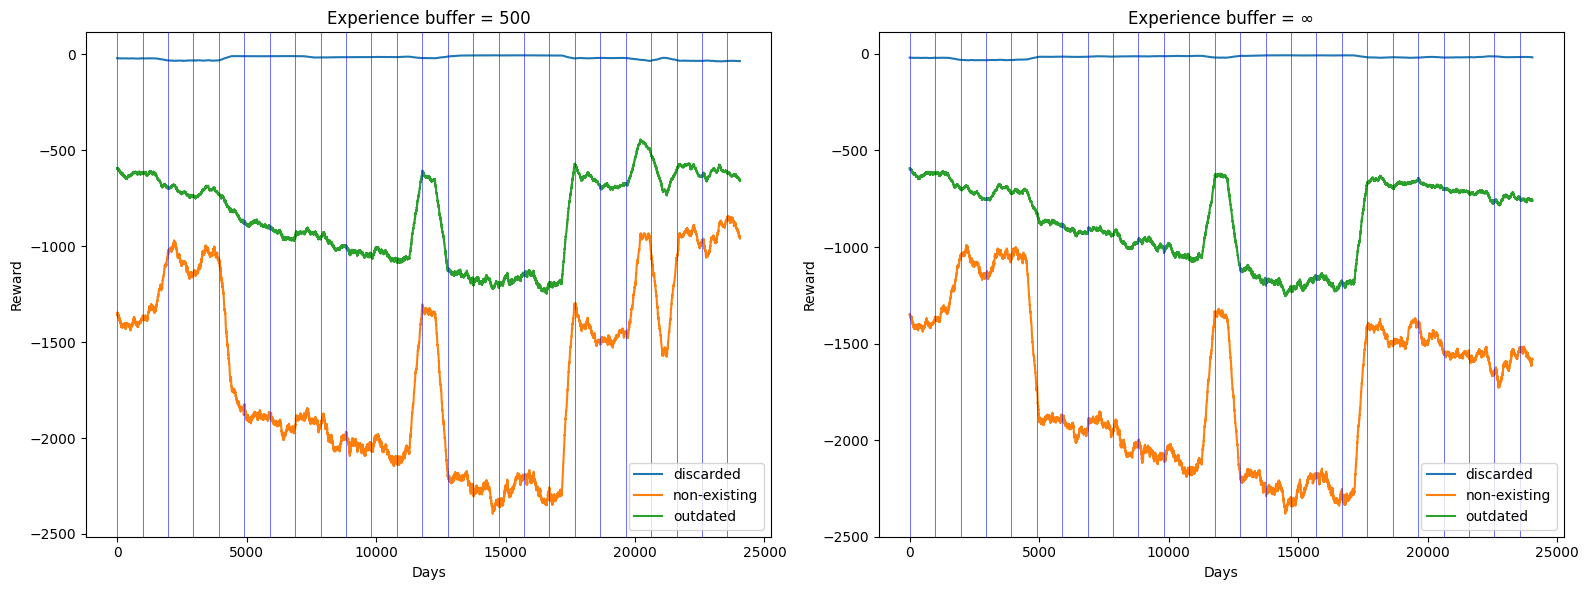

In [18]:
plot_multi(exps)

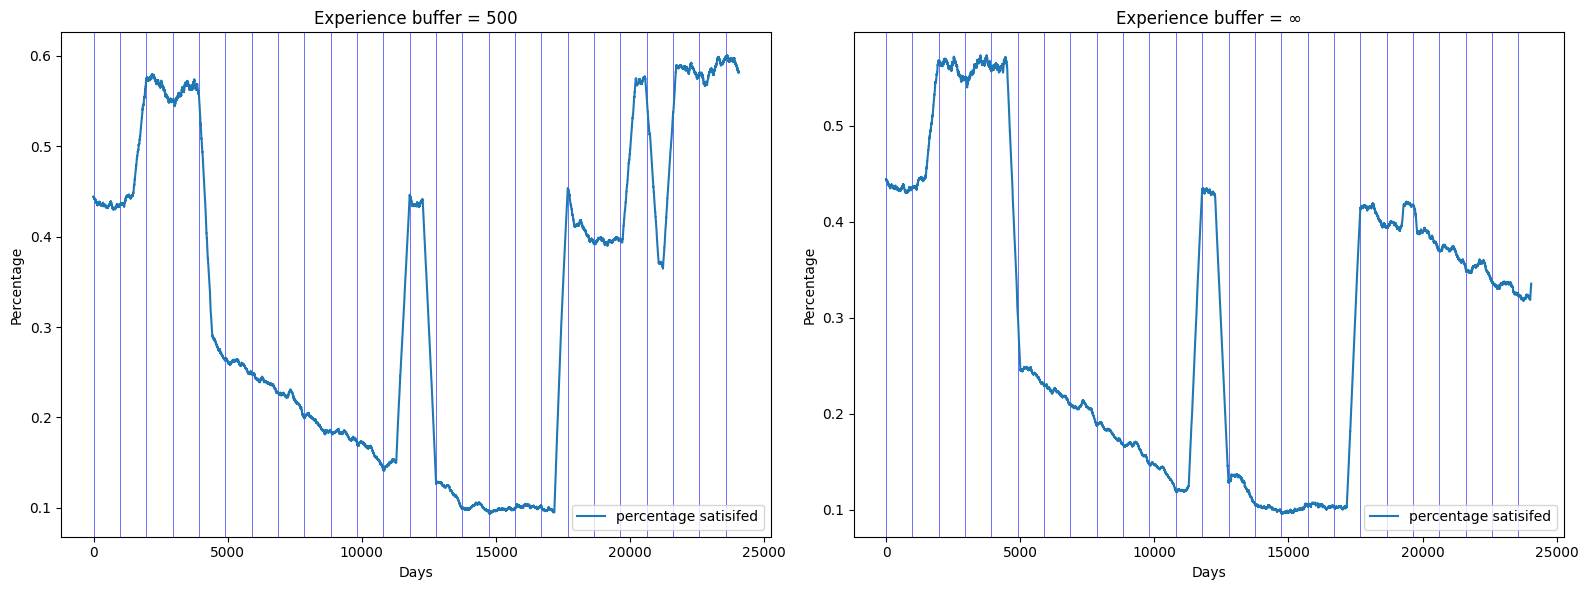

In [19]:
plot_multi_satisfied(exps)

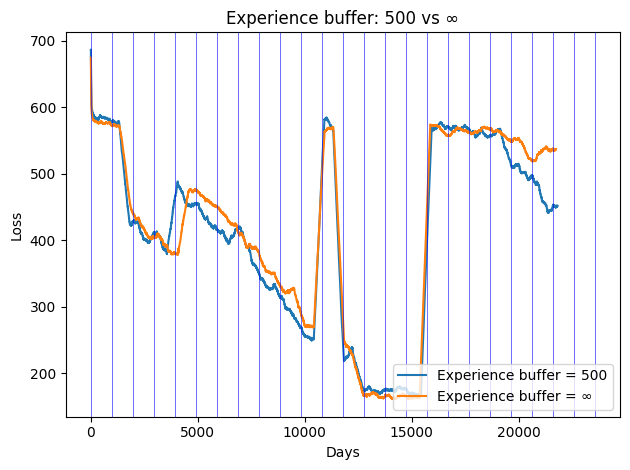

In [20]:
plot_loss_multi(exps, 'Experience buffer: 500 vs ∞')

#### 4 More target frequency tests

Network = [128, 128, 128]
Annealing epsilon: 1.0 - 0.01, ends at 80% of episodes (20)

Experience buffer = 500

Episode = 2.5 years
Episodes = 25

alpha = 0.001
gamma = 0.98

In [21]:
target_25 = read_csv('results/request_scratch/a0.001_g0.98_b50/128_128_128/freq_25')
target_50 = read_csv('results/request_scratch/a0.001_g0.98_b50/128_128_128/freq_50')

target25_50 = {'Frequency = 25': target_25, 'Frequency = 50:': target_50}

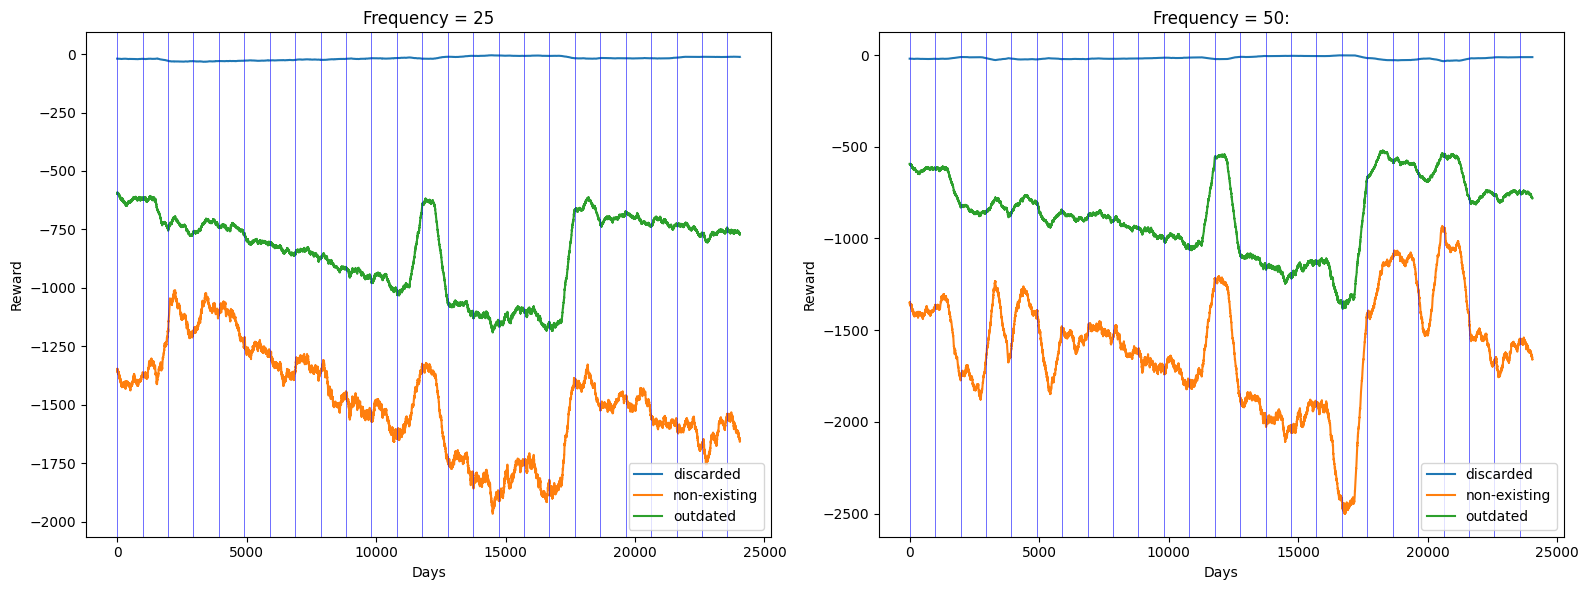

In [22]:
plot_multi(target25_50)

#### 5 Experience replay buffer tests

Network = [128, 128, 128]
Annealing epsilon: 1.0 - 0.01, ends at 80% of episodes (20)

Target frequency = 100

Episode = 2.5 years
Episodes = 25

alpha = 0.001

In [23]:
supplied = ['num_supplied_O-',
            'num_supplied_O+', 'num_supplied_B-', 'num_supplied_B+',
            'num_supplied_A-', 'num_supplied_A+', 'num_supplied_AB-',
            'num_supplied_AB+']

requests = ['num_requests_O-', 'num_requests_O+',
            'num_requests_B-', 'num_requests_B+', 'num_requests_A-',
            'num_requests_A+', 'num_requests_AB-', 'num_requests_AB+']

In [24]:
episode12 = df128_exp500[11 * 982:12 * 982]
episode13 = df128_exp500[12 * 982:13 * 982]
episode14 = df128_exp500[13 * 982:14 * 982]

In [16]:
loss = pd.read_csv('results/kickstart/loss_1.csv')

In [18]:
loss

,loss
0,0.086302
1,0.092568
2,0.101086
3,0.102304
4,0.071816
5,0.096090
6,0.084550
7,0.102185
8,0.082572
9,0.079747


<Axes: >

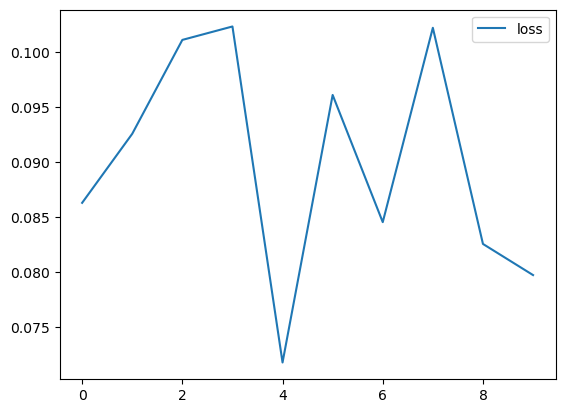

In [17]:
loss.plot()